In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import seaborn as sns
import warnings

warnings.simplefilter("ignore")
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports




# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold


from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

from functools import partial



# Loading and merging transaction and identity data into train and test datasets.

In [34]:
train_transaction = pd.read_csv('/Users/szeberinricsi/Documents/UPS/S2/MOST_AA/ieee-fraud-detection/train_transaction.csv')
train_identity = pd.read_csv("/Users/szeberinricsi/Documents/UPS/S2/MOST_AA/ieee-fraud-detection/train_identity.csv")
test_transaction = pd.read_csv("/Users/szeberinricsi/Documents/UPS/S2/MOST_AA/ieee-fraud-detection/test_transaction.csv")
test_identity = pd.read_csv("/Users/szeberinricsi/Documents/UPS/S2/MOST_AA/ieee-fraud-detection/test_identity.csv")

train_data = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test_data = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')




In [37]:
train_fraud = train_data[train_data.isFraud == 1]
train_nofraud = train_data[train_data.isFraud == 0]


In [39]:
train_data.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.000,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.000,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.500,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.000,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Difference in number of obseravations¶
There are less observations for identity than for transactions. All missing observations is replaced by NaN in the identity part.


### Information of Variables

According to the Data Description given by the data provider Vesta:

https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

#### Continuous Variables

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

TransactionAMT: transaction payment amount in USD

dist: May be the distance from addresses

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

D1-D15: timedelta, such as days between previous transaction, etc.

V1 - V339: Vesta engineered rich features, including ranking, counting, and other entity relations.

id_01 - id_11(In identity table)

#### Categorical Variables

From Transaction Table:

ProductCD: product code, the product for each transaction

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr1, addr2: both are for purchaser, addr1 as billing region, addr2 as billing country

Pemaildomain, Remaildomain: purchaser and recipient email domain

M1 - M9: match, such as names on card and address, etc.

From Identity Table:

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners.

id12 - id38, DeviceType, DeviceInfo


In [63]:
cat_cols = list(train_data.select_dtypes(include=['object']).columns)
cat_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

### Detection of Missing Values

The datasets have a big proportion of missing values, over 47% of features have more than 70% missing value.


In [4]:
summary = pd.DataFrame(train_data.dtypes, columns = ['Data Type'])
summary = summary.reset_index()
summary['Name'] = summary['index']
summary = summary.drop(columns=['index'])
summary['Missing(%)'] = train_data.isnull().sum().values / train_data.shape[0] * 100
summary['unique values'] = train_data.nunique().values
summary


,Data Type,Name,Missing(%),unique values
0,int64,TransactionID,0.000000,590540
1,int64,isFraud,0.000000,2
2,int64,TransactionDT,0.000000,573349
3,float64,TransactionAmt,0.000000,20902
4,object,ProductCD,0.000000,5
...,...,...,...,...
429,object,id_36,76.126088,2
430,object,id_37,76.126088,2
431,object,id_38,76.126088,2
432,object,DeviceType,76.155722,2



### Difference in number of obseravations¶
There are less observations for identity than for transactions. All missing observations is replaced by NaN in the identity part.

In [5]:
# Here we confirm that all of the transactions in `train_identity`
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907


- 24.4% of TransactionIDs in **train** (144233 / 590540) have an associated train_identity.
- 28.0% of TransactionIDs in **test** (144233 / 590540) have an associated train_identity.

# Variable analysis

## Transaction features

### Target Variable

In [7]:
print('  {:.4f}% of Transactions that are fraud in train '.format(train_transaction['isFraud'].mean() * 100))

  3.4990% of Transactions that are fraud in train 


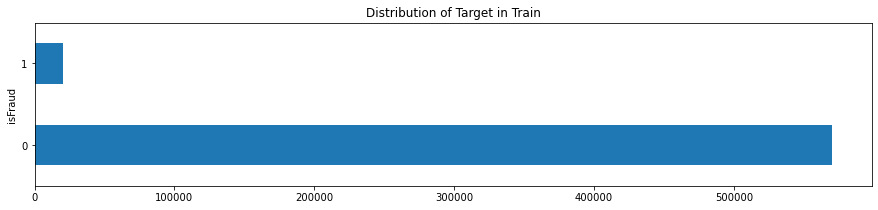

In [8]:
train_transaction.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='barh',
          title='Distribution of Target in Train',
          figsize=(15, 3))
plt.show()

### TransactionDT

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp). One early discovery about the data is that the train and test appear to be split by time. There is a slight gap inbetween, but otherwise the training set is from an earlier period of time and test is from a later period of time. This will impact which cross validation techniques should be used.

We will look into this more when reviewing differences in distribution of features between train and test.

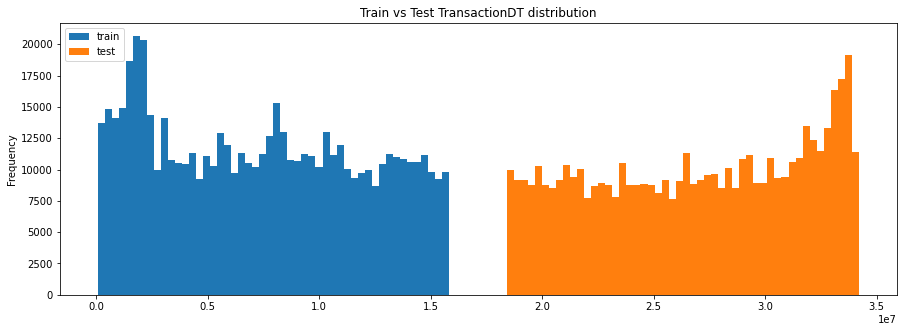

In [6]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

## TransactionAmt

The ammount of transaction. I've taken a log transform in some of these plots to better show the distribution- otherwise the few, very large transactions skew the distribution. Because of the log transfrom, any values between 0 and 1 will appear to be negative.

In [29]:
train_transaction['TransactionAmt'].describe()


count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

In [40]:
train_fraud['TransactionAmt'].describe()

count    20663.000000
mean       149.244779
std        232.212163
min          0.292000
25%         35.044000
50%         75.000000
75%        161.000000
max       5191.000000
Name: TransactionAmt, dtype: float64

In [9]:
print('Mean transaction amt for fraud is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is 149.2448
Mean transaction amt for non-fraud is 134.5117


# Categorical features

## ProductCD
- categorical feature
- For now we don't know exactly what these values represent.
- `W` has the most number of observations, `C` the least.
- ProductCD `C` has the most fraud with >11%
- ProductCD `W` has the least with ~2%

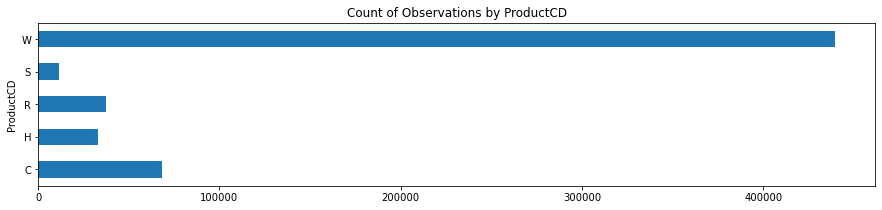

In [10]:
train_transaction.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Count of Observations by ProductCD')
plt.show()

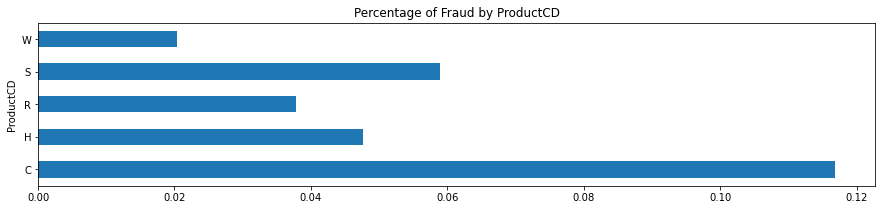

In [11]:
train_transaction.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

## card1 - card6
- We are told these are all categorical, even though some appear numeric.

In [13]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
train_transaction[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


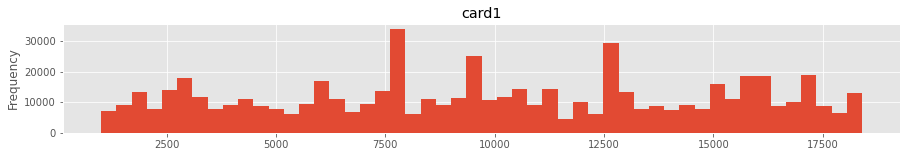

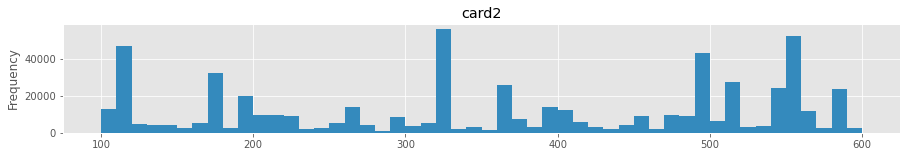

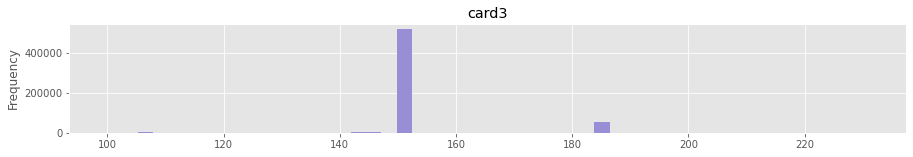

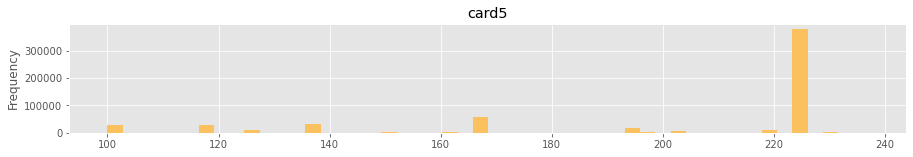

In [19]:
color_idx = 0
for c in card_cols:
    if train_transaction[c].dtype in ['float64','int64']:
        train_transaction[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

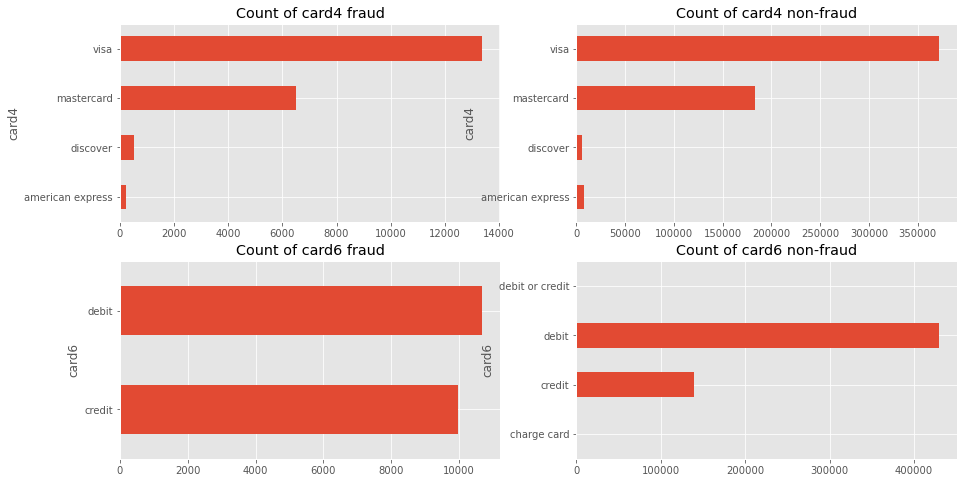

In [20]:
train_transaction_fr = train_transaction.loc[train_transaction['isFraud'] == 1]
train_transaction_nofr = train_transaction.loc[train_transaction['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_transaction_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

## addr1 & addr2
The data description states that these are categorical even though they look numeric. Perhaps they represent country (addr1) and region (addr2) codes.

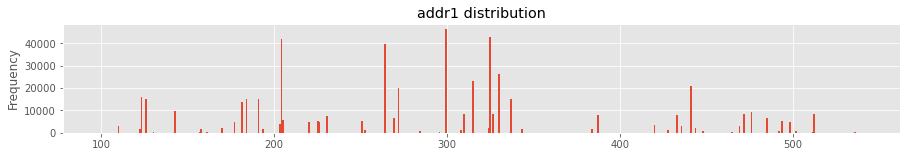

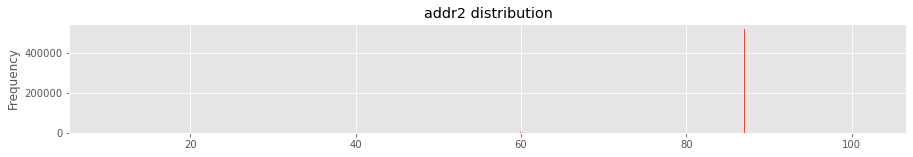

In [21]:
train_transaction['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution')
plt.show()
train_transaction['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution')
plt.show()

In [26]:
train_data['addr2'].value_counts(dropna=False, normalize=True).head()

87.0    0.881365
NaN     0.111264
60.0    0.005222
96.0    0.001080
32.0    0.000154
Name: addr2, dtype: float64

## dist1 & dist2
Plotting with logx to better show the distribution. Possibly this could be the distance of the transaction vs. the card owner's home/work/IP/phone/etc. address.

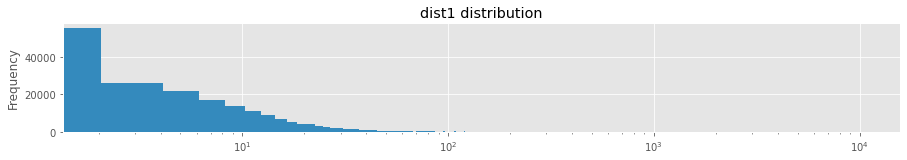

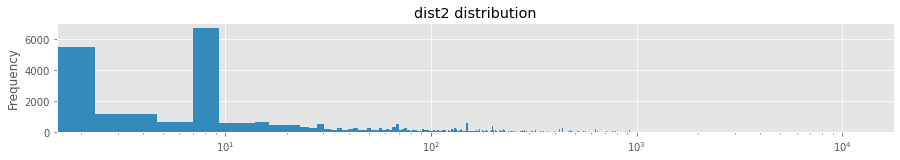

In [23]:
train_transaction['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()
train_transaction['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()

# C1 - C14
Because we are provided many numerical columns, we can create a pairplot to plot feature interactions. I know these plots can be hard to read, but it is helpful for gaining intution about potential feature interactions and if certain features have more variance than others.

In [27]:
Ccols= train_transaction.columns[train_transaction.columns.str.startswith('C')]
train_transaction[Ccols].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215
std,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,12.000000,2.000000
max,4685.000000,5691.000000,26.000000,2253.000000,349.000000,2253.000000,2255.000000,3331.000000,210.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


In [44]:
# Helper function for column value details

def column_value_freq(df,sel_col,cum_per):
    dfpercount = pd.DataFrame(columns=['col_name','num_values_99'])
    for col in sel_col:
        col_value = df[col].value_counts(normalize=True)
        colpercount = pd.DataFrame({'value' : col_value.index,'per_count' : col_value.values})
        colpercount['cum_per_count'] = colpercount['per_count'].cumsum()
        if len(colpercount.loc[colpercount['cum_per_count'] < cum_per,] ) < 2:
            num_col_99 = len(colpercount.loc[colpercount['per_count'] > (1- cum_per),])
        else:
            num_col_99 = len(colpercount.loc[colpercount['cum_per_count']< cum_per,] )
        dfpercount=dfpercount.append({'col_name': col,'num_values_99': num_col_99},ignore_index = True)
    dfpercount['unique_values'] = df[sel_col].nunique().values
    dfpercount['unique_value_to_num_values_99_ratio'] = 100 * (dfpercount.num_values_99/dfpercount.unique_values)
    dfpercount['percent_missing'] = percent_na(df[sel_col])['percent_missing'].round(3).values
    return dfpercount

def column_value_details(df,sel_col,cum_per):
    dfpercount = pd.DataFrame(columns=['col_name','values_'+str(round(cum_per,2)),'values_'+str(round(1-cum_per,2))])
    for col in sel_col:
        col_value = df[col].value_counts(normalize=True)
        colpercount = pd.DataFrame({'value' : col_value.index,'per_count' : col_value.values})
        colpercount['cum_per_count'] = colpercount['per_count'].cumsum()
        if len(colpercount.loc[colpercount['cum_per_count'] < cum_per,] ) < 2:
            values_freq = colpercount.loc[colpercount['per_count'] > (1- cum_per),'value'].tolist()
        else:
            values_freq = colpercount.loc[colpercount['cum_per_count']< cum_per,'value'].tolist() 
        values_less_freq =  [item for item in colpercount['value'] if item not in values_freq]
        dfpercount=dfpercount.append({'col_name': col,'values_'+str(round(cum_per,2)) : values_freq ,'values_'+str(round(1-cum_per,2)): values_less_freq},ignore_index = True)
    return dfpercount

# Helper functions
# 1. For calculating % na values in  columns
def percent_na(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': percent_missing.index,
                                 'percent_missing': percent_missing.values})
    return missing_value_df
# 2. For plotting grouped histograms 
def sephist(col):
    yes = train_transaction[train_transaction['isFraud'] == 1][col]
    no = train_transaction[train_transaction['isFraud'] == 0][col]
    return yes, no

The graph below shows number of unique values in each of the C Columns as blue bars.Orange bar shows the number of unique values in 96.5% of the data in each of the columns. The difference between the two bars is a measure of how distributed the data is across the range of unique values in the column.

Red line is the percentage of missing values in the columns.

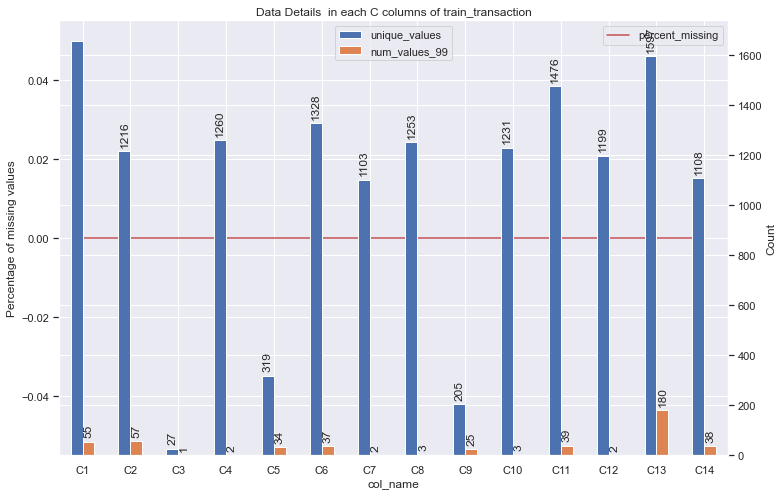

In [45]:
col_freq = column_value_freq(train_transaction,Ccols,0.965)
sns.set(rc={'figure.figsize':(12,8)})
plot=col_freq.plot(x='col_name',y='percent_missing',color='r')
plot.set(ylabel='Percentage of missing values')
ax1=plot.twinx()
#Dcol_freq['percent_missing'].plot(secondary_y=True, color='k', marker='o')
#Dcol_freq['unique_value_to_num_values_99_ratio'].plot(secondary_y=True, color='r', marker='o')
plot1=col_freq.plot(x='col_name',y=['unique_values','num_values_99'],ax=ax1,kind='bar')
for p in plot1.patches[1:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        plot1.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")
plot1.set(ylabel='Count')
plot= plot.set(title='Data Details  in each C columns of train_transaction')


Interesting to note that none of the C columns have missing values.

Across the range of values in each of the column few values make up 96.5% of data in each of the columns compared to total unique values.

Let's also look at test_transaction data set to verify whether the distribution of values are similiar

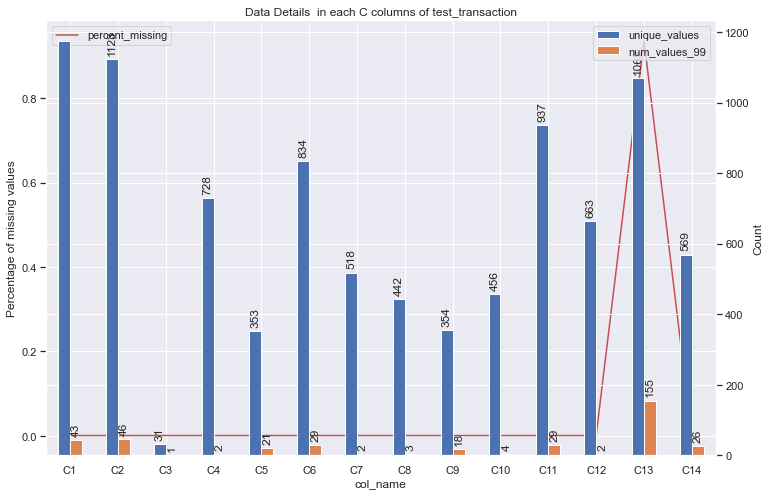

In [46]:
col_freq = column_value_freq(test_transaction,Ccols,0.965)
sns.set(rc={'figure.figsize':(12,8)})
plot=col_freq.plot(x='col_name',y='percent_missing',color='r')
plot.set(ylabel='Percentage of missing values')
ax1=plot.twinx()
#Dcol_freq['percent_missing'].plot(secondary_y=True, color='k', marker='o')
#Dcol_freq['unique_value_to_num_values_99_ratio'].plot(secondary_y=True, color='r', marker='o')
plot1=col_freq.plot(x='col_name',y=['unique_values','num_values_99'],ax=ax1,kind='bar')
for p in plot1.patches[1:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        plot1.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")
plot1.set(ylabel='Count')
plot= plot.set(title='Data Details  in each C columns of test_transaction')

Interestingly C13 has more than 90% missing values and C14 has 20% missing values. These features are potentially candidates to be dropped while building models.

### D1 - D9 
The plot below shows the data distribution in D columns



In [47]:
Dcols= train_transaction.columns[train_transaction.columns.str.startswith('D')]


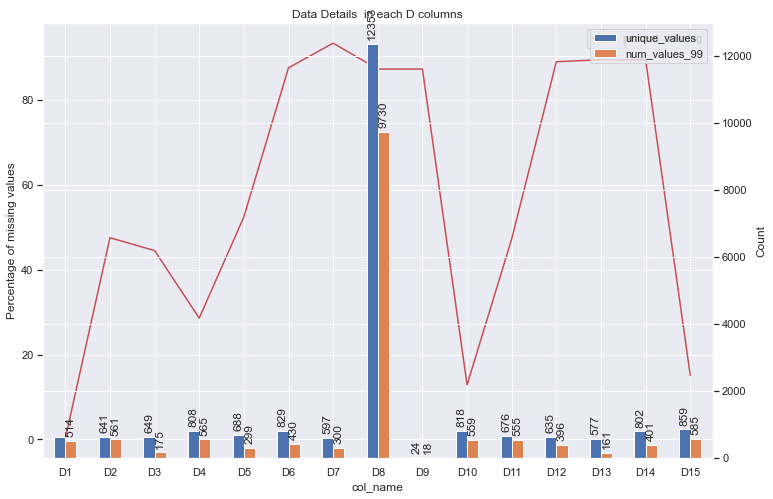

In [48]:
col_freq = column_value_freq(train_transaction,Dcols,0.965)
sns.set(rc={'figure.figsize':(12,8)})
plot=col_freq.plot(x='col_name',y='percent_missing',color='r')
plot.set(ylabel='Percentage of missing values')
ax1=plot.twinx()
#Dcol_freq['percent_missing'].plot(secondary_y=True, color='k', marker='o')
#Dcol_freq['unique_value_to_num_values_99_ratio'].plot(secondary_y=True, color='r', marker='o')
plot1=col_freq.plot(x='col_name',y=['unique_values','num_values_99'],ax=ax1,kind='bar')
for p in plot1.patches[1:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        plot1.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")
plot1.set(ylabel='Count')
plot= plot.set(title='Data Details  in each D columns')

From the above there is a fair uniform distribution of values in Dcolumns and these are truly numerical columns. histogram of data other than 0 and nulls are shown in the plot below.

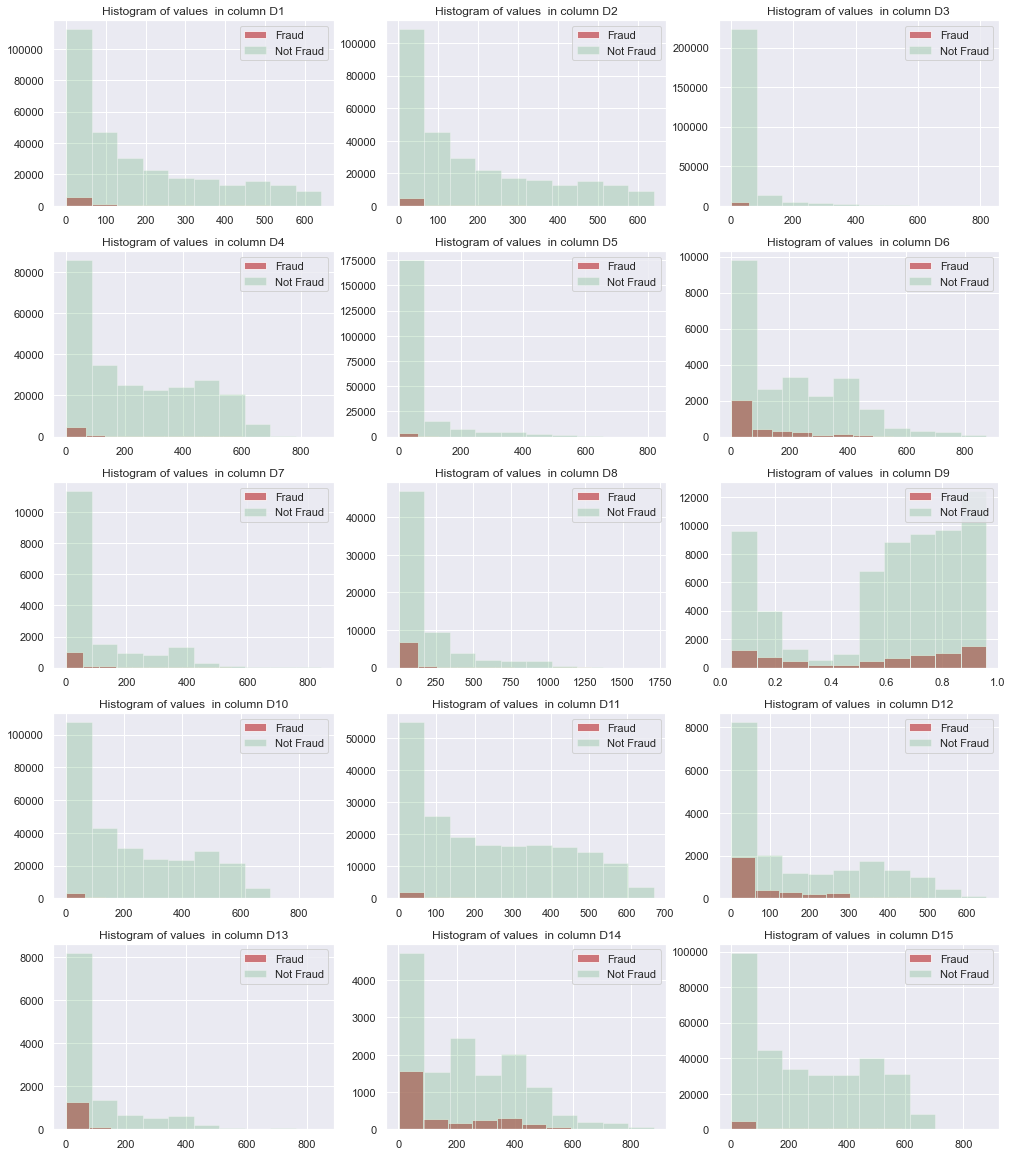

In [49]:
np.warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,16)})
for num, alpha in enumerate(Dcols):
    plt.subplot(5,3,num+1)
    yes = train_transaction[(train_transaction['isFraud'] == 1)][alpha]
    no = train_transaction[(train_transaction['isFraud'] == 0) ][alpha]
    plt.hist(yes[yes>0], alpha=0.75, label='Fraud', color='r')
    plt.hist(no[no>0], alpha=0.25, label='Not Fraud', color='g')
    plt.legend(loc='upper right')
    plt.title('Histogram of values  in column ' + str(alpha) )
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

From the above histogram D6,D7,D8,D12,D13,D14 seems to be number of days from some card event date .In any case thes columns have close to 90% null values.

### V columns

We notice that the first 100 Vs don't correlate much with the last 239 Vs. Also even though the first 100 have 6 different NAN groups there is much correlation between the groups. The latter 239 relate to each other. 

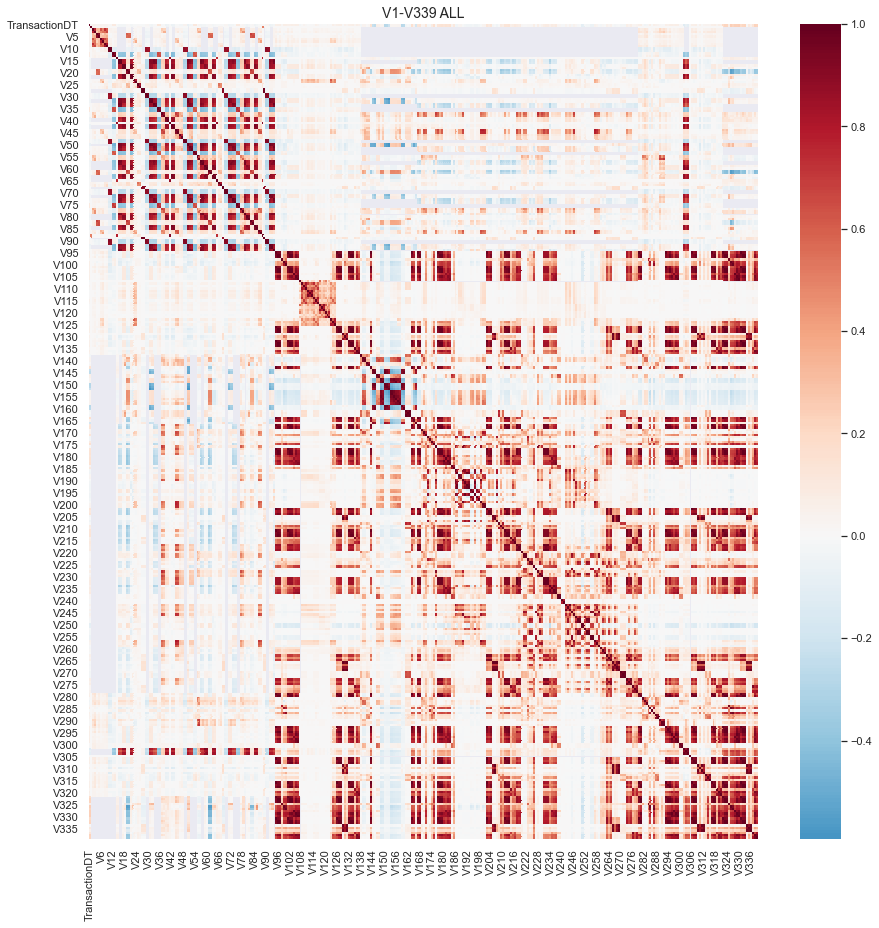

In [51]:
cols = ['TransactionDT'] + ['V'+str(x) for x in range(1,340)]
train2 = train_data[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 ALL',fontsize=14)
plt.show()